In [14]:
from new_main import *
import matplotlib.pyplot as plt

In [9]:
def simulation_run(alpha, publisher_list):
    print(f'Running simulation with alpha={alpha}')
    agent_stats = pd.DataFrame()
    comb_linucb = CombinatorialLinUCB(alpha=alpha, d=embedding_size, publisher_list=publisher_list)
    for i in range(num_iter):
        if i > 1:
            # After the first two iterations, run Combinatorial LinUCB to change the publisher list
            publisher_list = comb_linucb.round_iteration(publisher_list, iteration=i, soglia_spent=300)
        # Compute all agents' similarity with all publishers
        user_contexts, agents_publishers_similarity = initialize_deal(
            publisher_list, publisher_embeddings, rounds_per_iter, agents, adv_embeddings)
        # For each publisher, simulate rounds_per_iter opportunities
        for publisher in publisher_list:
            for j in range(rounds_per_iter):
                current_user_context = user_contexts[publisher.name][j]
                auction.simulate_opportunity(publisher.name, current_user_context, agents_publishers_similarity, j)
        # Update agents bidder and allocator models
        for agent_id, agent in enumerate(auction.agents):
            agent.update(iteration=i)
            # Our agent
            if agent.name.startswith('Nostro'):
                # Get stats for our agent
                agent_stats_pub = agent.iteration_stats_per_publisher()
                # Update Combinatorial LinUCB
                if i < 2:
                    # Initialize Combinatorial LinUCB parameters with the first two iterations
                    publishers_rewards = []
                    for publisher_data in agent_stats_pub:
                        curr_pub = Publisher(
                            name=publisher_data['publisher'],
                            embedding=publisher_embeddings[publisher_data['publisher']],
                            num_auctions=500
                        )
                        publishers_rewards.append(
                            PublisherReward(
                                publisher=curr_pub,
                                reward=publisher_data['num_clicks']
                            )
                        )
                    comb_linucb.initial_round(publishers_rewards, iteration=i)
                else:
                    # Update Combinatorial LinUCB after seeing the rewards
                    for publisher_data in agent_stats_pub:
                        comb_linucb.update(
                            publisher_name=publisher_data['publisher'],
                            publisher_embedding=publisher_embeddings[publisher_data['publisher']],
                            reward=publisher_data['num_clicks'],
                            iteration=i
                        )
                # Save stats for our agent
                agent_df = pd.DataFrame(agent_stats_pub)
                agent_df['Agent'] = agent.name
                agent_df['Iteration'] = i
                if i == 0:
                    agent_stats = agent_df
                else:
                    agent_stats = pd.concat([agent_stats, agent_df])
                # Print stats for our agent
                print(f"Stats after iteration {i}")
                print(f"Number of publishers: {len(agent_df['publisher'].unique())}")
                print(f"Number of clicks at iteration {i}: {agent_df['num_clicks'].sum()}")
                print(f"Spent at iteration {i}: {agent_df['spent'].sum()}")
                # Save stats in Combinatorial LinUCB
                # Group by publisher if there are more than one iteration data
                grouped_data = agent_df.groupby(by=['publisher']) \
                    .sum() \
                    .reset_index() \
                    [['publisher', 'won_auctions', 'lost_auctions', 'num_clicks', 'spent']]
                grouped_data['cpc'] = grouped_data.apply(lambda row: row['spent'] / row['num_clicks'] if row['num_clicks'] > 0 else 0, axis=1)
                comb_linucb.save_stats(grouped_data)

            agent.clear_utility()
            agent.clear_logs()

        auction.clear_revenue()
    # Save LinUCB parameters
    linucb_params = comb_linucb.linucb_params
    # Merge with previously saved parameters
    merged_df = pd.merge(
        agent_stats,
        linucb_params,
        on=['publisher', 'Iteration'],
        how='outer'
    )
    return agent_stats, merged_df

In [4]:
# Parse configuration file
rng, config, agent_configs, agents2items, agents2item_values, num_runs, max_slots, embedding_size, embedding_var, obs_embedding_size, adv_embeddings, publisher_embeddings = parse_config('../new_config/FP_Truthful_Oracle_alpha_tune.json')

In [5]:
agents = instantiate_agents(rng, agent_configs, agents2item_values, agents2items)
auction, num_iter, rounds_per_iter, output_dir = instantiate_auction(rng, config, agents2items, agents2item_values, agents, max_slots, embedding_size, embedding_var, obs_embedding_size)
publishers = instantiate_publishers(publisher_embeddings)

In [6]:
# Choose 300 publishers at random
rng.shuffle(publishers)
publisher_list = publishers[:300]

In [7]:
alpha_list = [0, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6]

In [10]:
alpha_results = {
    alpha: simulation_run(alpha, publisher_list)
    for alpha in alpha_list
}

Running simulation with alpha=0


/Users/giovanni/PycharmProjects/auction-gym/src/CombinatorialLinUCB.py:79: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.linucb_params = pd.concat([


Stats after iteration 0
Number of publishers: 300
Number of clicks at iteration 0: 15919.0
Spent at iteration 0: 817.0313590940507
Stats after iteration 1
Number of publishers: 300
Number of clicks at iteration 1: 8380.0
Spent at iteration 1: 430.5520774797815
Knapsack Solver: Soluzione ottimale trovata!
Spent = 299.9952575897177
Stats after iteration 2
Number of publishers: 128
Number of clicks at iteration 2: 6239.0
Spent at iteration 2: 316.342090240689
Knapsack Solver: Soluzione ottimale trovata!
Spent = 299.96019763989653
Stats after iteration 3
Number of publishers: 123
Number of clicks at iteration 3: 6032.0
Spent at iteration 3: 310.32975341492084
Knapsack Solver: Soluzione ottimale trovata!
Spent = 299.9669514822856
Stats after iteration 4
Number of publishers: 118
Number of clicks at iteration 4: 6177.0
Spent at iteration 4: 316.52985177237167
Knapsack Solver: Soluzione ottimale trovata!
Spent = 299.98421702338396
Stats after iteration 5
Number of publishers: 108
Number of cl

/Users/giovanni/PycharmProjects/auction-gym/src/CombinatorialLinUCB.py:79: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.linucb_params = pd.concat([


Stats after iteration 0
Number of publishers: 300
Number of clicks at iteration 0: 7934.0
Spent at iteration 0: 406.1068615967933
Stats after iteration 1
Number of publishers: 300
Number of clicks at iteration 1: 8246.0
Spent at iteration 1: 419.3052795150618
Knapsack Solver: Soluzione ottimale trovata!
Spent = 299.9740546234093
Stats after iteration 2
Number of publishers: 218
Number of clicks at iteration 2: 5918.0
Spent at iteration 2: 306.7660003386011
Knapsack Solver: Soluzione ottimale trovata!
Spent = 299.9522649095767
Stats after iteration 3
Number of publishers: 215
Number of clicks at iteration 3: 6191.0
Spent at iteration 3: 316.6089438213903
Knapsack Solver: Soluzione ottimale trovata!
Spent = 299.950675988105
Stats after iteration 4
Number of publishers: 202
Number of clicks at iteration 4: 6086.0
Spent at iteration 4: 306.5877022675285
Knapsack Solver: Soluzione ottimale trovata!
Spent = 299.9363365422459
Stats after iteration 5
Number of publishers: 199
Number of clicks 

/Users/giovanni/PycharmProjects/auction-gym/src/CombinatorialLinUCB.py:79: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.linucb_params = pd.concat([


Stats after iteration 0
Number of publishers: 300
Number of clicks at iteration 0: 7941.0
Spent at iteration 0: 407.11949264445366
Stats after iteration 1
Number of publishers: 300
Number of clicks at iteration 1: 8187.0
Spent at iteration 1: 422.05205393745547
Knapsack Solver: Soluzione ottimale trovata!
Spent = 299.98714833039315
Stats after iteration 2
Number of publishers: 221
Number of clicks at iteration 2: 6356.0
Spent at iteration 2: 323.6985160551334
Knapsack Solver: Soluzione ottimale trovata!
Spent = 299.96004124133947
Stats after iteration 3
Number of publishers: 209
Number of clicks at iteration 3: 6153.0
Spent at iteration 3: 315.2522523609995
Knapsack Solver: Soluzione ottimale trovata!
Spent = 299.96285229320233
Stats after iteration 4
Number of publishers: 204
Number of clicks at iteration 4: 5581.0
Spent at iteration 4: 284.3609737240564
Knapsack Solver: Soluzione ottimale trovata!
Spent = 299.98290704892815
Stats after iteration 5
Number of publishers: 202
Number of 

/Users/giovanni/PycharmProjects/auction-gym/src/CombinatorialLinUCB.py:79: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.linucb_params = pd.concat([


Stats after iteration 0
Number of publishers: 300
Number of clicks at iteration 0: 8290.0
Spent at iteration 0: 425.2755223346237
Stats after iteration 1
Number of publishers: 300
Number of clicks at iteration 1: 7825.0
Spent at iteration 1: 403.5678592294829
Knapsack Solver: Soluzione ottimale trovata!
Spent = 299.9859861811416
Stats after iteration 2
Number of publishers: 227
Number of clicks at iteration 2: 6502.0
Spent at iteration 2: 324.869853808639
Knapsack Solver: Soluzione ottimale trovata!
Spent = 299.9948175451027
Stats after iteration 3
Number of publishers: 213
Number of clicks at iteration 3: 6241.0
Spent at iteration 3: 320.42517701694436
Knapsack Solver: Soluzione ottimale trovata!
Spent = 299.98417791652264
Stats after iteration 4
Number of publishers: 198
Number of clicks at iteration 4: 5737.0
Spent at iteration 4: 293.30238503738684
Knapsack Solver: Soluzione ottimale trovata!
Spent = 299.9758335145305
Stats after iteration 5
Number of publishers: 202
Number of clic

/Users/giovanni/PycharmProjects/auction-gym/src/CombinatorialLinUCB.py:79: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.linucb_params = pd.concat([


Stats after iteration 0
Number of publishers: 300
Number of clicks at iteration 0: 7847.0
Spent at iteration 0: 404.0603599330207
Stats after iteration 1
Number of publishers: 300
Number of clicks at iteration 1: 8229.0
Spent at iteration 1: 416.6367964028324
Knapsack Solver: Soluzione ottimale trovata!
Spent = 299.9913552937935
Stats after iteration 2
Number of publishers: 238
Number of clicks at iteration 2: 6606.0
Spent at iteration 2: 337.0707196619325
Knapsack Solver: Soluzione ottimale trovata!
Spent = 299.96361069232375
Stats after iteration 3
Number of publishers: 217
Number of clicks at iteration 3: 5798.0
Spent at iteration 3: 296.9526896989523
Knapsack Solver: Soluzione ottimale trovata!
Spent = 299.95409608071014
Stats after iteration 4
Number of publishers: 212
Number of clicks at iteration 4: 5603.0
Spent at iteration 4: 287.13070694187263
Knapsack Solver: Soluzione ottimale trovata!
Spent = 299.9944240282499
Stats after iteration 5
Number of publishers: 218
Number of cli

/Users/giovanni/PycharmProjects/auction-gym/src/CombinatorialLinUCB.py:79: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.linucb_params = pd.concat([


Stats after iteration 0
Number of publishers: 300
Number of clicks at iteration 0: 7849.0
Spent at iteration 0: 398.2590071676153
Stats after iteration 1
Number of publishers: 300
Number of clicks at iteration 1: 8414.0
Spent at iteration 1: 431.71844940824917
Knapsack Solver: Soluzione ottimale trovata!
Spent = 299.97805157578733
Stats after iteration 2
Number of publishers: 241
Number of clicks at iteration 2: 6181.0
Spent at iteration 2: 313.86218738435457
Knapsack Solver: Soluzione ottimale trovata!
Spent = 299.98527737721713
Stats after iteration 3
Number of publishers: 227
Number of clicks at iteration 3: 5662.0
Spent at iteration 3: 291.3329917811619
Knapsack Solver: Soluzione ottimale trovata!
Spent = 299.9689506933513
Stats after iteration 4
Number of publishers: 225
Number of clicks at iteration 4: 6303.0
Spent at iteration 4: 318.25256353898084
Knapsack Solver: Soluzione ottimale trovata!
Spent = 299.99348027659414
Stats after iteration 5
Number of publishers: 214
Number of 

/Users/giovanni/PycharmProjects/auction-gym/src/CombinatorialLinUCB.py:79: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.linucb_params = pd.concat([


Stats after iteration 0
Number of publishers: 300
Number of clicks at iteration 0: 8114.0
Spent at iteration 0: 417.1286627964815
Stats after iteration 1
Number of publishers: 300
Number of clicks at iteration 1: 7990.0
Spent at iteration 1: 410.93627449823884
Knapsack Solver: Soluzione ottimale trovata!
Spent = 299.99825544424726
Stats after iteration 2
Number of publishers: 236
Number of clicks at iteration 2: 6605.0
Spent at iteration 2: 338.0819336995364
Knapsack Solver: Soluzione ottimale trovata!
Spent = 299.98218074676697
Stats after iteration 3
Number of publishers: 211
Number of clicks at iteration 3: 5666.0
Spent at iteration 3: 290.0898185676339
Knapsack Solver: Soluzione ottimale trovata!
Spent = 299.9746772412704
Stats after iteration 4
Number of publishers: 215
Number of clicks at iteration 4: 5892.0
Spent at iteration 4: 301.62979198988853
Knapsack Solver: Soluzione ottimale trovata!
Spent = 299.9951863170945
Stats after iteration 5
Number of publishers: 217
Number of cl

/Users/giovanni/PycharmProjects/auction-gym/src/CombinatorialLinUCB.py:79: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.linucb_params = pd.concat([


Stats after iteration 0
Number of publishers: 300
Number of clicks at iteration 0: 8539.0
Spent at iteration 0: 433.2220966710423
Stats after iteration 1
Number of publishers: 300
Number of clicks at iteration 1: 8602.0
Spent at iteration 1: 435.98307617912394
Knapsack Solver: Soluzione ottimale trovata!
Spent = 299.9918926123475
Stats after iteration 2
Number of publishers: 243
Number of clicks at iteration 2: 6170.0
Spent at iteration 2: 315.67185383770766
Knapsack Solver: Soluzione ottimale trovata!
Spent = 299.97107534441375
Stats after iteration 3
Number of publishers: 228
Number of clicks at iteration 3: 6211.0
Spent at iteration 3: 315.21543267326933
Knapsack Solver: Soluzione ottimale trovata!
Spent = 299.99316886066845
Stats after iteration 4
Number of publishers: 221
Number of clicks at iteration 4: 5882.0
Spent at iteration 4: 298.0239346582372
Knapsack Solver: Soluzione ottimale trovata!
Spent = 299.9952722892236
Stats after iteration 5
Number of publishers: 217
Number of c

/Users/giovanni/PycharmProjects/auction-gym/src/CombinatorialLinUCB.py:79: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.linucb_params = pd.concat([


Stats after iteration 0
Number of publishers: 300
Number of clicks at iteration 0: 7999.0
Spent at iteration 0: 413.39212128905353
Stats after iteration 1
Number of publishers: 300
Number of clicks at iteration 1: 8471.0
Spent at iteration 1: 433.243327469459
Knapsack Solver: Soluzione ottimale trovata!
Spent = 299.96202279062095
Stats after iteration 2
Number of publishers: 234
Number of clicks at iteration 2: 5942.0
Spent at iteration 2: 305.0719387851198
Knapsack Solver: Soluzione ottimale trovata!
Spent = 299.9514674649183
Stats after iteration 3
Number of publishers: 223
Number of clicks at iteration 3: 5929.0
Spent at iteration 3: 303.0981736406965
Knapsack Solver: Soluzione ottimale trovata!
Spent = 299.9844992199487
Stats after iteration 4
Number of publishers: 218
Number of clicks at iteration 4: 6271.0
Spent at iteration 4: 324.1362267750981
Knapsack Solver: Soluzione ottimale trovata!
Spent = 299.98807422372454
Stats after iteration 5
Number of publishers: 202
Number of clic

In [58]:
# Add num_clicks without noise
for alpha, results in alpha_results.items():
    agent_stats, lin_ucb_params = results
    agent_stats['num_clicks_no_noise'] = agent_stats['won_auctions'] * agent_stats['true_ctr']
    lin_ucb_params['num_clicks_no_noise'] = lin_ucb_params['won_auctions'] * lin_ucb_params['true_ctr']

In [59]:
def process_results(alpha_results):
    grouped_results = {}
    for alpha, results in alpha_results.items():
        agent_stats, lin_ucb_params = results
        lin_ucb_params_train = lin_ucb_params[lin_ucb_params['Iteration'] > 1]
        group_iter = lin_ucb_params_train.groupby('Iteration') \
            .agg({'num_clicks': 'sum', 'exp_rew': 'sum', 'spent': 'sum', 'num_clicks_no_noise': 'sum'}) \
            .reset_index()
        group_iter['abs_err'] = np.abs(group_iter['num_clicks'] - group_iter['exp_rew'])
        group_iter['abs_perc_err'] = np.abs(group_iter['num_clicks'] - group_iter['exp_rew']) / group_iter['num_clicks']
        grouped_results[alpha] = group_iter
    return grouped_results

In [60]:
grouped_results = process_results(alpha_results)

## Save results

In [68]:
save_dir = '../results/alpha_tuning/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [70]:
for alpha, results in alpha_results.items():
    agent_stats, lin_ucb_params = results
    lin_ucb_params.to_csv(os.path.join(save_dir, f'agent_stats_alpha_{alpha}.csv'), index=False)
for alpha, results in grouped_results.items():
    results.to_csv(os.path.join(save_dir, f'grouped_results_per_iter_alpha_{alpha}.csv'), index=False)

In [61]:
def plot_results(grouped_results):
    # Plot absolute percentage error
    for alpha, results in grouped_results.items():
        plt.plot(results.index.to_numpy(), results['abs_perc_err'].to_numpy(), label=f'Alpha={alpha}')
    plt.xlabel('Iteration')
    plt.ylabel('Absolute percentage error')
    plt.legend()
    # Plot expected reward
    plt.figure()
    for alpha, results in grouped_results.items():
        plt.plot(results.index.to_numpy(), results['exp_rew'].to_numpy(), label=f'Alpha={alpha}')
    plt.xlabel('Iteration')
    plt.ylabel('Expected reward')
    # Plot number of clicks
    plt.figure()
    for alpha, results in grouped_results.items():
        plt.plot(results.index.to_numpy(), results['num_clicks'].to_numpy(), label=f'Alpha={alpha}')
    plt.xlabel('Iteration')
    plt.ylabel('Number of clicks')
    # Plot number of clicks without noise
    plt.figure()
    for alpha, results in grouped_results.items():
        plt.plot(results.index.to_numpy(), results['num_clicks_no_noise'].to_numpy(), label=f'Alpha={alpha}')
    plt.xlabel('Iteration')
    plt.ylabel('Number of clicks without noise')
    plt.show()

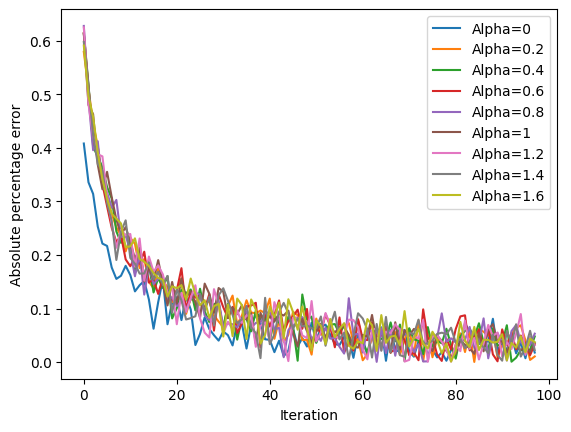

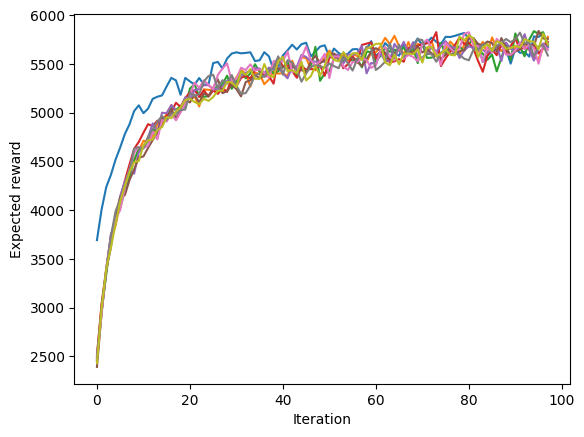

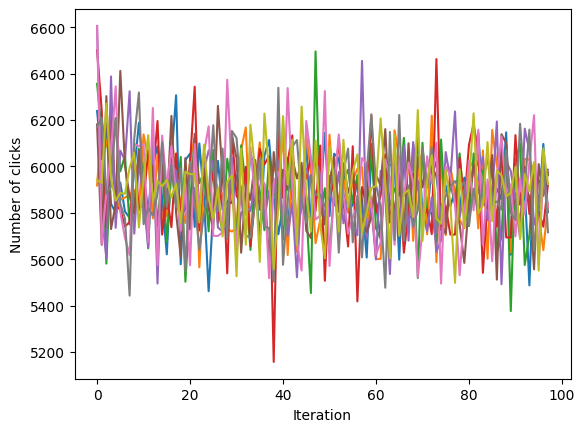

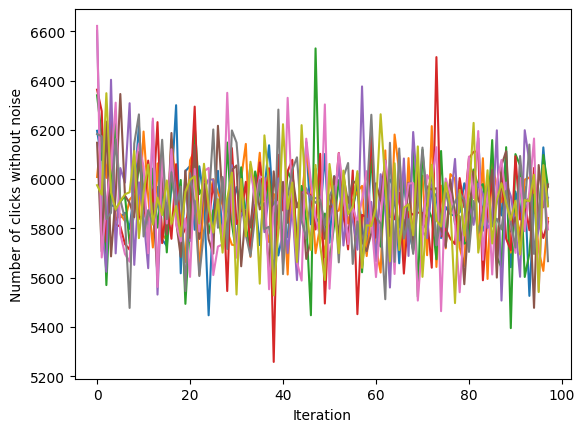

In [62]:
plot_results(grouped_results)

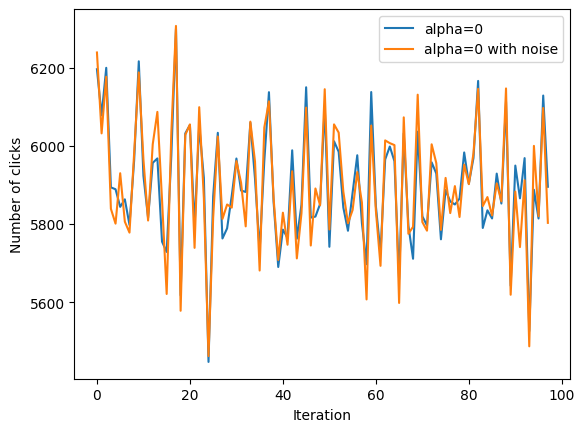

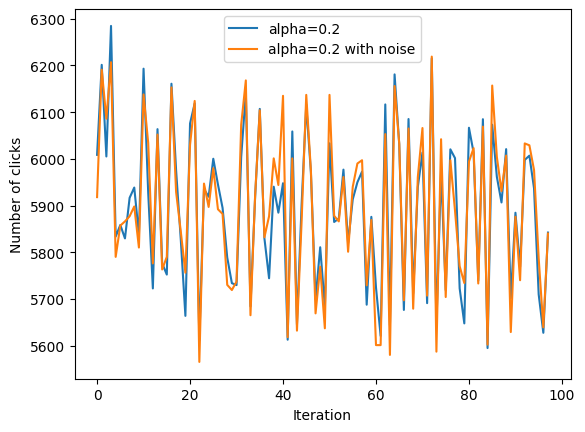

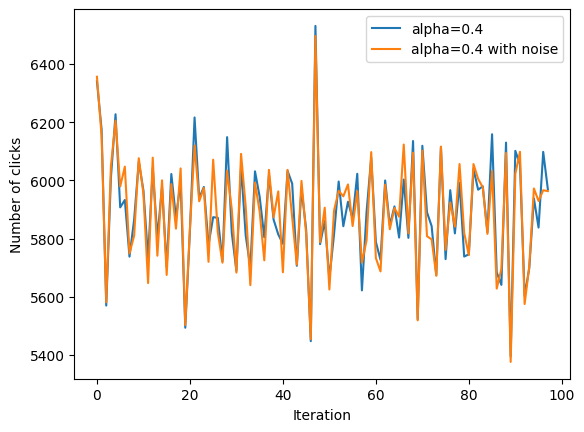

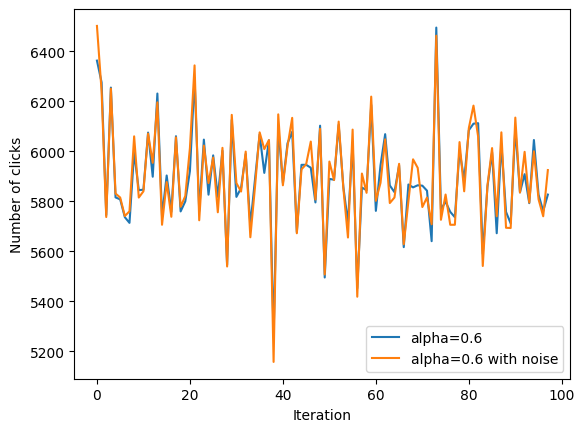

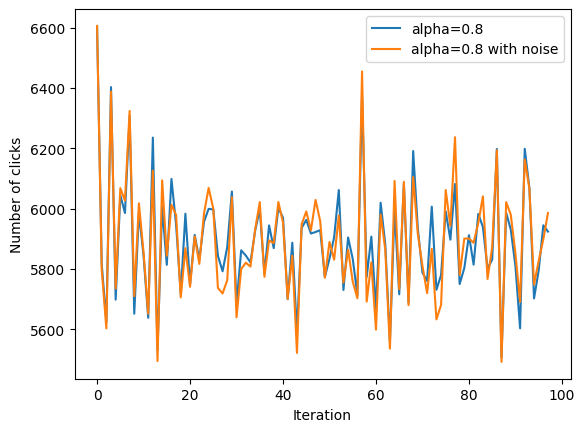

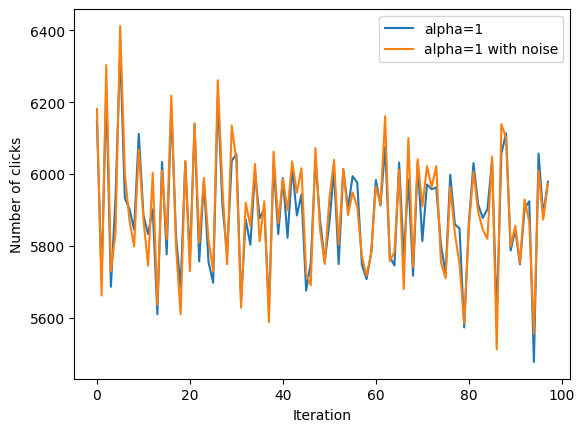

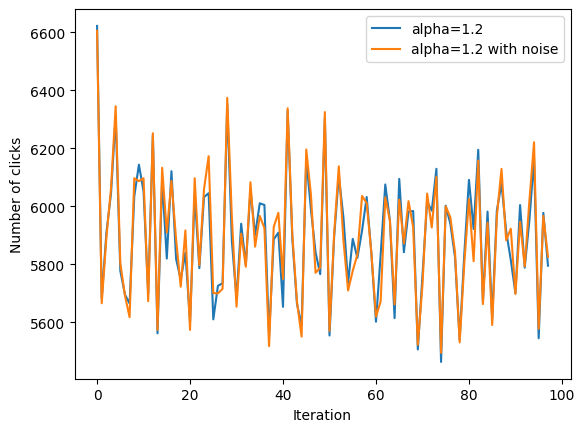

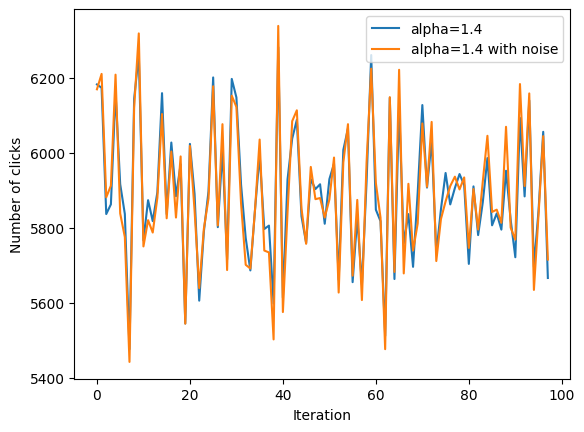

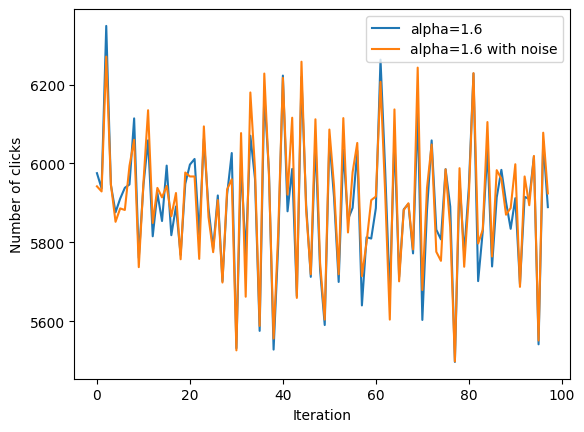

In [67]:
# Plot number of clicks without noise for each alpha with a separate plot
for alpha, results in grouped_results.items():
    plt.plot(results.index.to_numpy(), results['num_clicks_no_noise'].to_numpy(), label=f'alpha={alpha}')
    plt.plot(results.index.to_numpy(), results['num_clicks'].to_numpy(), label=f'alpha={alpha} with noise')
    plt.xlabel('Iteration')
    plt.ylabel('Number of clicks')
    plt.legend()
    plt.show()

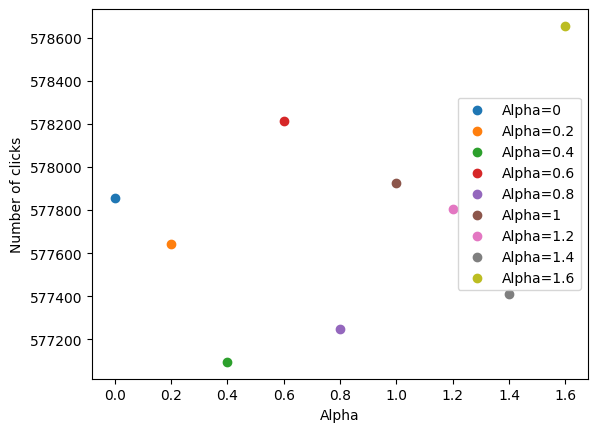

In [55]:
# Plot number of clicks and alpha
for alpha, results in grouped_results.items():
    plt.scatter(alpha, results['num_clicks'].sum(), label=f'Alpha={alpha}')
plt.xlabel('Alpha')
plt.ylabel('Number of clicks')
plt.legend()
plt.show()

## Controllare che nelle prime 2 iterazioni ci sia almeno un sample per ogni publisher

In [71]:
alpha = 0

In [72]:
agent_stats, lin_ucb_params = alpha_results[alpha]

In [73]:
agent_stats[agent_stats['Iteration'] == 0]['publisher'].nunique()

300

In [74]:
agent_stats[agent_stats['Iteration'] == 1]['publisher'].nunique()

300

## Quanti publisher sono stati scelti in ogni iterazione?

<AxesSubplot:xlabel='Iteration'>

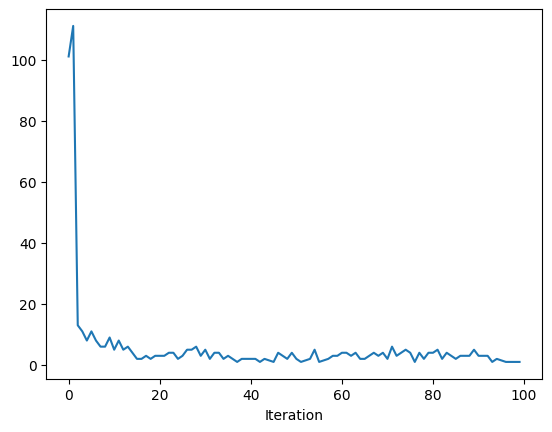

In [79]:
lin_ucb_params[lin_ucb_params['num_clicks'] == 0].groupby('Iteration').size().plot()

<AxesSubplot:xlabel='Iteration'>

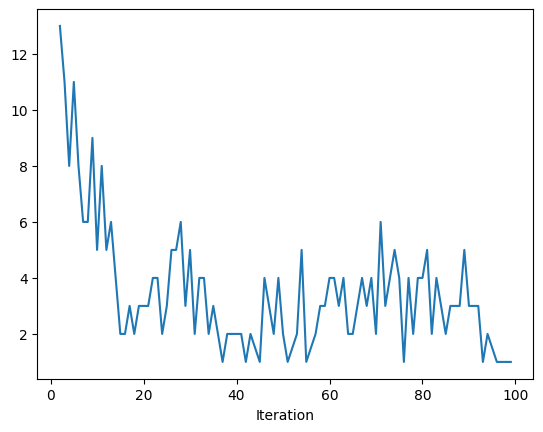

In [80]:
# Dopo le prime 2 iterazioni
lin_ucb_params[(lin_ucb_params['Iteration'] > 1) & (lin_ucb_params['num_clicks'] == 0)].groupby('Iteration').size().plot()

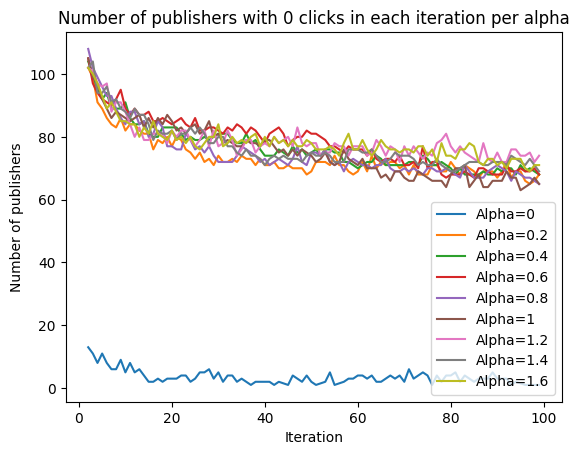

In [84]:
# Stessa cosa ma per ogni alpha
for alpha, results in alpha_results.items():
    agent_stats, lin_ucb_params = results
    lin_ucb_params[(lin_ucb_params['Iteration'] > 1) & (lin_ucb_params['num_clicks'] == 0)].groupby('Iteration').size().plot(label=f'Alpha={alpha}')
    plt.title("Number of publishers that generates 0 clicks in each iteration per alpha")
    plt.xlabel('Iteration')
    plt.ylabel('Number of publishers')
    plt.legend()

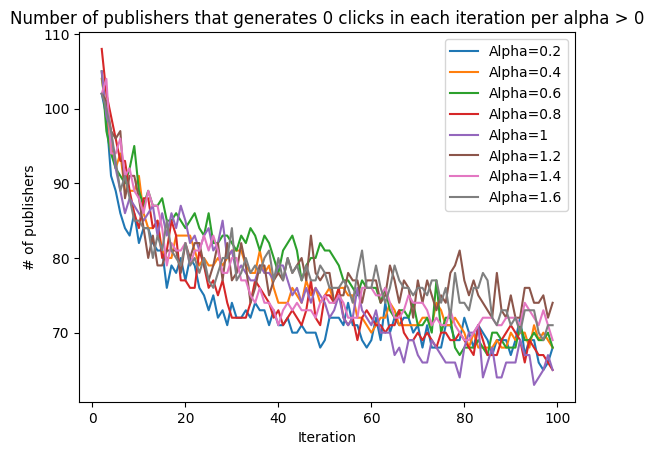

In [87]:
# Vedere solo con alpha > 0
for alpha, results in alpha_results.items():
    if alpha == 0:
        continue
    agent_stats, lin_ucb_params = results
    lin_ucb_params[(lin_ucb_params['Iteration'] > 1) & (lin_ucb_params['num_clicks'] == 0)].groupby('Iteration').size().plot(label=f'Alpha={alpha}')
    plt.title("Number of publishers that generates 0 clicks in each iteration per alpha > 0")
    plt.xlabel('Iteration')
    plt.ylabel('# of publishers')
    plt.legend()

 ## Quanti publisher che hanno generato 0 clicks sono stati scelti in ogni iterazione in percentuale?

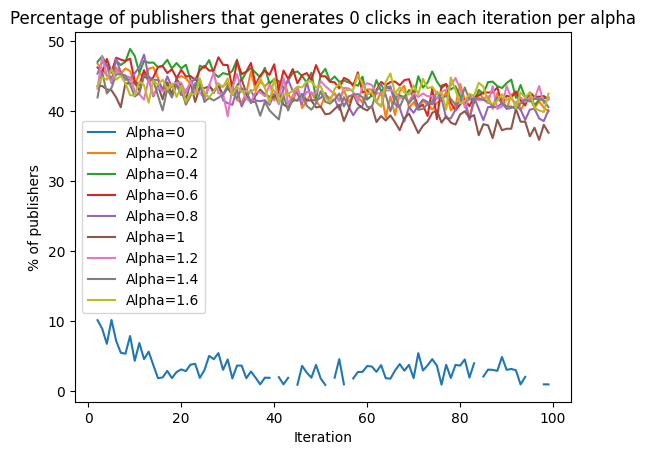

In [91]:
for alpha, results in alpha_results.items():
    agent_stats, lin_ucb_params = results
    zero_clicks = lin_ucb_params[(lin_ucb_params['Iteration'] > 1) & (lin_ucb_params['num_clicks'] == 0)].groupby('Iteration').size()
    total = lin_ucb_params[(lin_ucb_params['Iteration'] > 1)].groupby('Iteration').size()
    perc_zero_clicks = (zero_clicks / total) * 100
    perc_zero_clicks.plot(label=f'Alpha={alpha}')
    plt.title("Percentage of publishers that generates 0 clicks in each iteration per alpha")
    plt.xlabel('Iteration')
    plt.ylabel('% of publishers')
    plt.legend()